In [1]:
import azureml.core
from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig
from azureml.core.environment import DockerBuildContext
print("SDK version:", azureml.core.VERSION)
from datetime import datetime
datetime.now()

SDK version: 1.47.0


datetime.datetime(2023, 3, 2, 14, 41, 1, 743516)

In [2]:
use_gpu = True


In [3]:
from azureml.core import Dataset
from azureml.data import OutputFileDatasetConfig

ws = Workspace.from_config()
datastore = ws.get_default_datastore()
datafldr_path = Dataset.File.from_files(datastore.path('credit_risk_data/')).as_named_input('data').as_mount()
output = OutputFileDatasetConfig(destination=(datastore, 'outputs/profiles/')).as_upload(overwrite=True)

years = [2007, 2008, 2009]
years = ",".join(map(str, years))

In [4]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

datastore = ws.get_default_datastore()
print("Default datastore's name: {}".format(datastore.name))

gpu-eastus-ws
aml-resources
eastus
abf00999-14b9-4c55-8975-c472a54c14c3
Default datastore's name: workspaceblobstore


In [5]:
experiment_name = 'credit-default-risk-sample'
experiment = Experiment(workspace=ws, name=experiment_name)


In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

if use_gpu:
    cluster_name = 'Standard-NC12s-v3' #'gpu-cluster'
else:
    cluster_name = 'cpu-cluster'

if cluster_name in ws.compute_targets:
    gpu_cluster = ws.compute_targets[cluster_name]
    if gpu_cluster and type(gpu_cluster) is AmlCompute:
        print('Found compute target. Will use {0} '.format(cluster_name))
else:
    print('creating new cluster')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = 'Standard_NC12s_v3',  #'Standard_M128s'
                                                                max_nodes = 1,
                                                                idle_seconds_before_scaledown = 600,
                                                                vm_priority = "lowpriority")
    
    gpu_cluster = ComputeTarget.create(ws, cluster_name, provisioning_config)
    gpu_cluster.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
# use get_status() to get a detailed status for the current cluster 
print(gpu_cluster.get_status().serialize())

Found compute target. Will use Standard-NC12s-v3 
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 1, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2023-03-02T14:24:43.832000+00:00', 'errors': None, 'creationTime': '2023-03-02T10:40:40.619883+00:00', 'modifiedTime': '2023-03-02T10:40:47.432797+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': 'PT600S'}, 'vmPriority': 'LowPriority', 'vmSize': 'STANDARD_NC12S_V3'}


In [7]:
from azureml.core import Workspace, Environment
ws = Workspace.from_config()
env_list = Environment.list(ws)
env = Environment.get(workspace=ws, name="credit")

env.docker.enabled = True
env.docker.base_image = None
env.python.user_managed_dependencies = True
env.environment_variables = None
env.python.interpreter_path = "/opt/conda/envs/rapids/bin/python"


'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.
Property environment_variables is deprecated. Use RunConfiguration.environment_variables to set runtime variables.


In [8]:
config = ScriptRunConfig(source_directory="./src", script="main.py", compute_target=gpu_cluster, environment=env, 
    arguments =[datafldr_path, years],
    # docker_runtime_config=docker_config,
)
run = experiment.submit(config)
print(run)

print(run.wait_for_completion(show_output=True))

Run(Experiment: credit-default-risk-sample,
Id: credit-default-risk-sample_1677768096_c9599951,
Type: azureml.scriptrun,
Status: Preparing)
RunId: credit-default-risk-sample_1677768096_c9599951
Web View: https://ml.azure.com/runs/credit-default-risk-sample_1677768096_c9599951?wsid=/subscriptions/abf00999-14b9-4c55-8975-c472a54c14c3/resourcegroups/aml-resources/workspaces/gpu-eastus-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming user_logs/std_log.txt

[2007, 2008, 2009] <class 'list'> <class 'int'>
Reading the file Acquisition_2007Q1.txt
Reading the file Acquisition_2007Q2.txt
Reading the file Acquisition_2007Q3.txt
Reading the file Acquisition_2007Q4.txt
Reading the file Acquisition_2008Q1.txt
Reading the file Acquisition_2008Q2.txt
Reading the file Acquisition_2008Q3.txt
Reading the file Acquisition_2008Q4.txt
Reading the file Acquisition_2009Q1.txt
Reading the file Acquisition_2009Q2.txt
Reading the file Acquisition_2009Q3.txt
Reading the file Acquisition_2009Q4.txt
Dataframe

In [9]:
metrics = run.get_metrics()
metrics

{'ROC': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1677768096_c9599951//assets/ROC.png',
 'SHAP': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1677768096_c9599951//assets/shap.png',
 'Importance Scores': 'aml://artifactId/ExperimentRun/dcid.credit-default-risk-sample_1677768096_c9599951//assets/importance.png'}

In [10]:
run.get_file_names()

['assets/ROC.png',
 'assets/importance.png',
 'assets/shap.png',
 'system_logs/cs_capability/cs-capability.log',
 'system_logs/data_capability/data-capability.log',
 'system_logs/data_capability/rslex.log.2023-03-02-14',
 'system_logs/hosttools_capability/hosttools-capability.log',
 'system_logs/lifecycler/execution-wrapper.log',
 'system_logs/lifecycler/lifecycler.log',
 'system_logs/metrics_capability/metrics-capability.log',
 'system_logs/snapshot_capability/snapshot-capability.log',
 'user_logs/std_log.txt']

In [11]:
os.makedirs('files', exist_ok=True)

for f in run.get_file_names():
    if not f.startswith('assets'):
        continue
    dest = os.path.join('files', f.split('/')[-1])
    print('Downloading file {} to {}...'.format(f, dest))
    run.download_file(f, dest)   


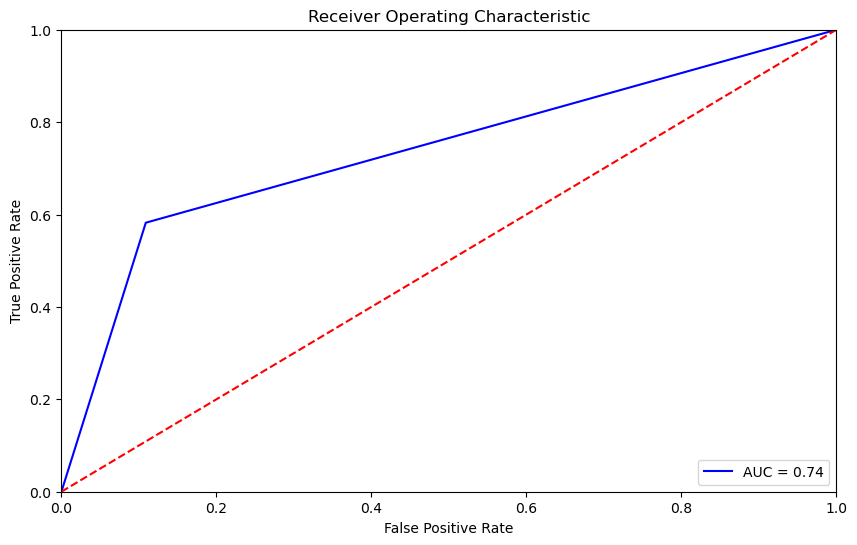

In [12]:
from IPython.display import Image
Image(filename='files/ROC.png') 

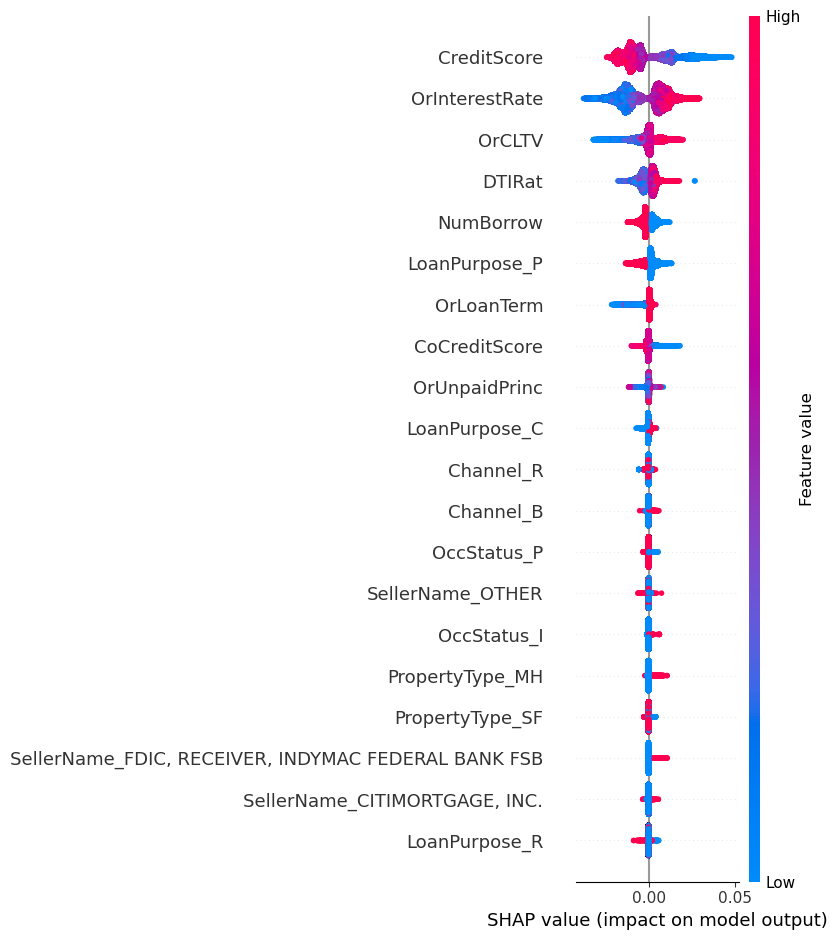

In [13]:
from IPython.display import Image
Image(filename='files/shap.png') 